# Day 20 KDE(Kernel Density Estimation) in Practice
本小节中, 将遇到一种图像特征提取技术——<font color='red'>方向梯度直方图(Histogram of Oriented Gradients，HOG)。它可以将图像像素转换成向量形式</font>(可参考[如何理解方向梯度直方图](https://www.leiphone.com/news/201708/ZKsGd2JRKr766wEd.html))， 与图像具体内容有关，与图像合成因素无关，如照度(illumination)。我们将根据这些特 征，使用前面介绍过的机器学习算法和内容开发一个简单的人脸识别.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1.HOG特征

方向梯度直方图是一个简单的特征提取程序，专门用来识别有行人(pedestrians)的图像
内容。HOG 方法包含以下五个步骤:
1. 图像标准化(可选)，消除照度对图像的影响。
2. 用与水平和垂直方向的亮度梯度相关的两个过滤器处理图像，捕捉图像的边、角和纹理
信息。
3. 将图像切割成预定义大小的图块，然后计算每个图块内梯度方向的频次直方图。
4. 对比每个图块与相邻图块的频次直方图，并做标准化处理，进一步消除照度对图像的
影响。
5. 获得描述每个图块信息的一维特征向量。

Scikit-Image 项目内置了一个快速的 HOG 提取器，可以用它快速获取并可视化每个图块的方向梯度:

In [2]:
from skimage import data, color, feature
import skimage.data

In [3]:
data.chelsea().shape

(300, 451, 3)

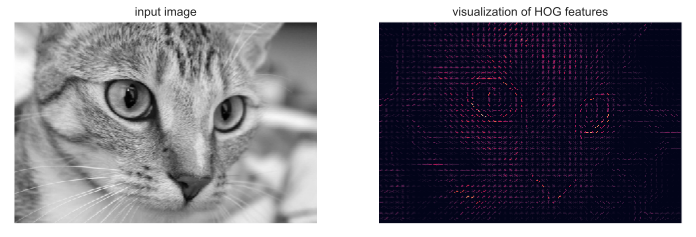

In [4]:
image = color.rgb2gray(data.chelsea())
#skimage_deprecation: Default value of block_norm==L1 is deprecated and will be changed to L2-Hys in v0.15
#'be changed to L2-Hys in v0.15', skimage_deprecation
hog_vec, hog_vis = feature.hog(image, block_norm='L2-Hys', visualize=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## 2.HOG实战:简单人脸识别器
有了图像的 HOG 特征后，就可以用 Scikit-Learn 的任意评估器建立一个简单人脸识别算 法，这里使用线性支持向量机:

* 获取一组人脸图像缩略图，构建“正”(positive)训练样本。
* 获取另一组人脸图像缩略图，构建“负”(negative)训练样本。
* 提取训练样本的 HOG 特征。
*  对样本训练一个线性 SVM 模型。
*  为“未知”图像传递一个移动的窗口，用模型评估窗口中的内容是否是人脸。 (6) 如果发现和已知图像重叠，就将它们组合成一个窗口。

(1) 获取一组正训练样本。

首先找一些能体现人脸变化的图像作为正训练样本。获取这些图像的方法很简单—— Wild 数据集里面带标签的人脸图像就是，用 Scikit-Learn 可以直接下载:

In [5]:
from sklearn.datasets import fetch_lfw_people
import warnings

warnings.filterwarnings(action='ignore')

faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(462, 62, 47)

(2) 获取一组负训练样本。

之后需要获取一组近似大小的缩略图，但它们不在训练样本中。解决这个问题的一种方法是引入别的图像语料库，然后再按需求抽取缩略图。这里使用 Scikit-Image 的图像数 据，再用 Scikit-Image 的 PatchExtractor 提取缩略图:

In [6]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [7]:
# np.vstack?

In [8]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis]) #先flat再resize
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

现在就有了 30 000 张尺寸合适、未经识别的图像。先来看一些图像:

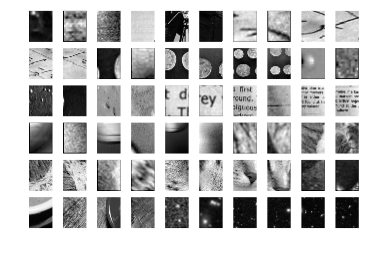

In [9]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

(3) 组合数据集并提取 HOG 特征。

现在就有了正样本和负样本。将它们组合起来，然后计算 HOG 特征。

In [10]:
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [11]:
X_train.shape

(30462, 1215)

这样，我们就获得了 30462 个训练样本，每个样本有 1215 个特征.

(4) 训练一个支持向量机。

这里用 Scikit-Learn 的 LinearSVC，因为 它比 SVC 更适合处理大样本数据。
首先，用简单的高斯朴素贝叶斯分类器算一个初始解:

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.96159149, 0.92850108, 0.97331101])

对于训练数据，即使用简单的朴素贝叶斯算法也可以获得 90% 以上的准确率。现在再用支持向量机分类，用网格搜索获取最优的边界软化参数 C:

In [13]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9972096382378045

In [14]:
grid.best_params_

{'C': 2.0}

用最优的评估器重新训练数据集:

In [15]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

(5) 在新图像中寻找人脸。

模型已经训练完成，让我们拿一张新图像检验模型的训练效果。使用一张宇航员照片的局部图像, 在上面运行一个移动窗口来评估每次移动的结果:

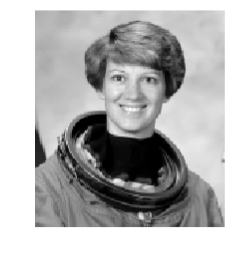

In [16]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

然后，创建一个不断在图像中移动的窗口，然后计算每次移动位置的 HOG 特征:

In [17]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

最后，收集这些 HOG 特征，并用训练好的模型来评估每个窗口中是否有人脸:

In [18]:
labels = model.predict(patches_hog)
labels.sum()

9.0

在近 2000 幅图像中，总共发现了 9 幅带人脸的图像。用矩形把收集到的信息画在图像上:

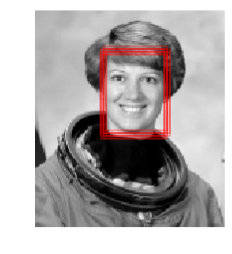

In [19]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))